# Benchmark summary

Load the collected benchmarks, aggregate mean/std over seeds, and plot mean time vs dimension for each backend (float32 only), split by device.

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

data_path = Path("measurements/benchmark_all.csv")
df = pd.read_csv(data_path)
df.head()

,backend,dtype,dim,kappa,seed,time_s,number,uses_householder,inplace,device,num_samples
0,numpy,<class 'numpy.float16'>,1024,50,0,5.869413,1,False,False,cpu,5000
1,numpy,<class 'numpy.float16'>,1024,50,1,0.248838,1,False,False,cpu,5000
2,numpy,<class 'numpy.float16'>,1024,50,2,13.806088,20,False,False,cpu,5000
3,numpy,<class 'numpy.float16'>,1024,50,3,1.492317,1,False,False,cpu,5000
4,numpy,<class 'numpy.float16'>,1024,50,4,0.233848,22,False,False,cpu,5000


In [2]:
# Filter to rows where float32 is in the dtype
df32 = df.loc[df["dtype"].str.contains("float32")]

summary = (
    df32.groupby(["backend", "device", "dim"], as_index=False)["time_s"]
    .agg(mean_time_s="mean", std_time_s="std", n="count")
    .sort_values(["device", "backend", "dim"])
)

summary.head()

,backend,device,dim,mean_time_s,std_time_s,n
0,numpy,cpu,2,0.001102,1.157275e-06,5
1,numpy,cpu,4,0.001237,1.034964e-06,5
2,numpy,cpu,8,0.001518,4.589879e-07,5
3,numpy,cpu,16,0.002491,1.718456e-06,5
4,numpy,cpu,32,0.004740,6.433284e-05,5


## Aggregated table (mean/std by backend, device, dim)

In [3]:
summary

,backend,device,dim,mean_time_s,std_time_s,n
0,numpy,cpu,2,0.001102,1.157275e-06,5
1,numpy,cpu,4,0.001237,1.034964e-06,5
2,numpy,cpu,8,0.001518,4.589879e-07,5
3,numpy,cpu,16,0.002491,1.718456e-06,5
4,numpy,cpu,32,0.004740,6.433284e-05,5
...,...,...,...,...,...,...
119,torch_hh_inplace_cuda,cuda,256,0.002434,6.662323e-06,5
120,torch_hh_inplace_cuda,cuda,512,0.002145,1.600593e-06,5
121,torch_hh_inplace_cuda,cuda,1024,0.002272,1.041033e-06,5
122,torch_hh_inplace_cuda,cuda,2048,0.002577,3.508343e-06,5


## Mean time vs dimension (float32), split by device

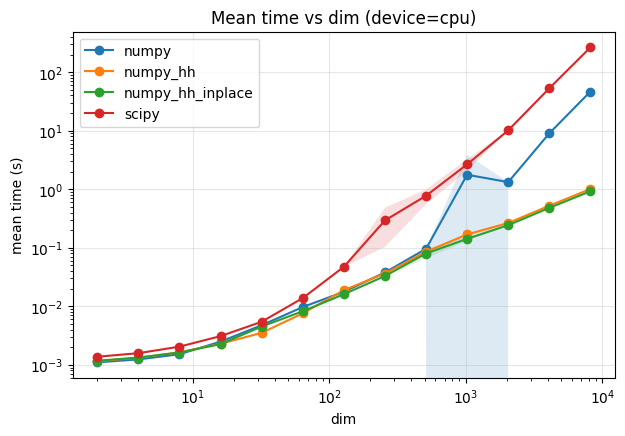

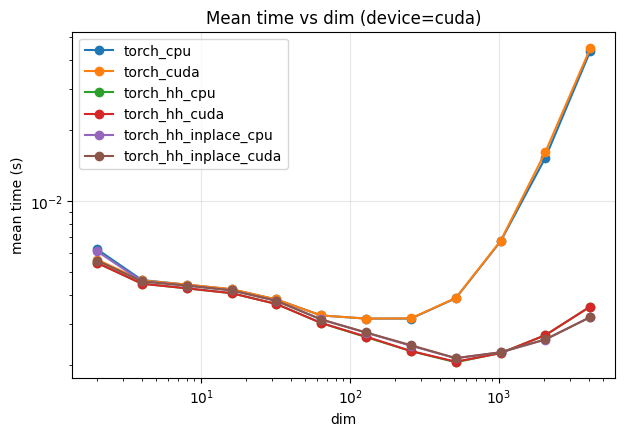

In [7]:
devices = sorted(summary["device"].unique())
backends = sorted(summary["backend"].unique())

for device in devices:
    subset = summary[summary["device"] == device]
    fig, ax = plt.subplots(figsize=(7, 4.5))
    for backend in backends:
        data = subset[subset["backend"] == backend]
        if data.empty:
            continue
        ax.plot(data["dim"], data["mean_time_s"], marker="o", label=backend)
        ax.fill_between(
            data["dim"],
            data["mean_time_s"] - data["std_time_s"],
            data["mean_time_s"] + data["std_time_s"],
            alpha=0.15,
        )
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(f"Mean time vs dim (device={device})")
    ax.set_xlabel("dim")
    ax.set_ylabel("mean time (s)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()

## Pivot table for quick comparison

In [5]:
pivot = summary.pivot_table(
    index=["device", "dim"],
    columns="backend",
    values="mean_time_s",
)

pivot

backend          numpy  numpy_hh  numpy_hh_inplace       scipy  torch_cpu  \
device dim                                                                  
cpu    2      0.001102  0.001153          0.001174    0.001374        NaN   
       4      0.001237  0.001322          0.001328    0.001581        NaN   
       8      0.001518  0.001635          0.001623    0.002043        NaN   
       16     0.002491  0.002292          0.002257    0.003092        NaN   
       32     0.004740  0.003518          0.004501    0.005436        NaN   
       64     0.009696  0.007572          0.008225    0.013797        NaN   
       128    0.017656  0.018848          0.016072    0.047202        NaN   
       256    0.037787  0.036303          0.032866    0.292674        NaN   
       512    0.095862  0.085519          0.079726    0.772560        NaN   
       1024   1.766774  0.168634          0.141975    2.656934        NaN   
       2048   1.321545  0.264837          0.243541   10.128340        NaN   
       4096   9.010419  0.522626          0.480276   53.025934        NaN   
       8192  46.624137  1.009005          0.922147  264.807701        NaN   
cuda   2           NaN       NaN               NaN         NaN   0.006238   
       4           NaN       NaN               NaN         NaN   0.004612   
       8           NaN       NaN               NaN         NaN   0.004410   
       16          NaN       NaN               NaN         NaN   0.004211   
       32          NaN       NaN               NaN         NaN   0.003811   
       64          NaN       NaN               NaN         NaN   0.003259   
       128         NaN       NaN               NaN         NaN   0.003160   
       256         NaN       NaN               NaN         NaN   0.003161   
       512         NaN       NaN               NaN         NaN   0.003859   
       1024        NaN       NaN               NaN         NaN   0.006739   
       2048        NaN       NaN               NaN         NaN   0.015320   
       4096        NaN       NaN               NaN         NaN   0.043522   

backend      torch_cuda  torch_hh_cpu  torch_hh_cuda  torch_hh_inplace_cpu  \
device dim                                                                   
cpu    2            NaN           NaN            NaN                   NaN   
       4            NaN           NaN            NaN                   NaN   
       8            NaN           NaN            NaN                   NaN   
       16           NaN           NaN            NaN                   NaN   
       32           NaN           NaN            NaN                   NaN   
       64           NaN           NaN            NaN                   NaN   
       128          NaN           NaN            NaN                   NaN   
       256          NaN           NaN            NaN                   NaN   
       512          NaN           NaN            NaN                   NaN   
       1024         NaN           NaN            NaN                   NaN   
       2048         NaN           NaN            NaN                   NaN   
       4096         NaN           NaN            NaN                   NaN   
       8192         NaN           NaN            NaN                   NaN   
cuda   2       0.005637      0.005457       0.005460              0.006117   
       4       0.004594      0.004452       0.004448              0.004558   
       8       0.004412      0.004251       0.004253              0.004364   
       16      0.004218      0.004056       0.004054              0.004167   
       32      0.003813      0.003648       0.003646              0.003761   
       64      0.003259      0.003025       0.003026              0.003134   
       128     0.003161      0.002635       0.002649              0.002754   
       256     0.003168      0.002298       0.002299              0.002422   
       512     0.003867      0.002060       0.002072              0.002143   
       1024    0.006775      0.002254       0.00

## GPU speedup vs CPU (where both available)

In [6]:
cpu = summary[summary["device"] == "cpu"].rename(columns={"mean_time_s": "cpu_mean"})
gpu = summary[summary["device"] == "gpu"].rename(columns={"mean_time_s": "gpu_mean"})

speedup = cpu.merge(
    gpu,
    on=["backend", "dim"],
    how="inner",
    suffixes=("_cpu", "_gpu"),
)

if not speedup.empty:
    speedup["speedup_cpu_over_gpu"] = speedup["cpu_mean"] / speedup["gpu_mean"]
    display(speedup[["backend", "dim", "speedup_cpu_over_gpu"]])

    fig, ax = plt.subplots(figsize=(7, 4.5))
    for backend in sorted(speedup["backend"].unique()):
        data = speedup[speedup["backend"] == backend]
        ax.plot(data["dim"], data["speedup_cpu_over_gpu"], marker="o", label=backend)

    ax.set_title("CPU / GPU mean time (speedup)")
    ax.set_xlabel("dim")
    ax.set_ylabel("speedup (higher is better)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()
else:
    print("No overlapping CPU/GPU entries to compute speedup.")

No overlapping CPU/GPU entries to compute speedup.


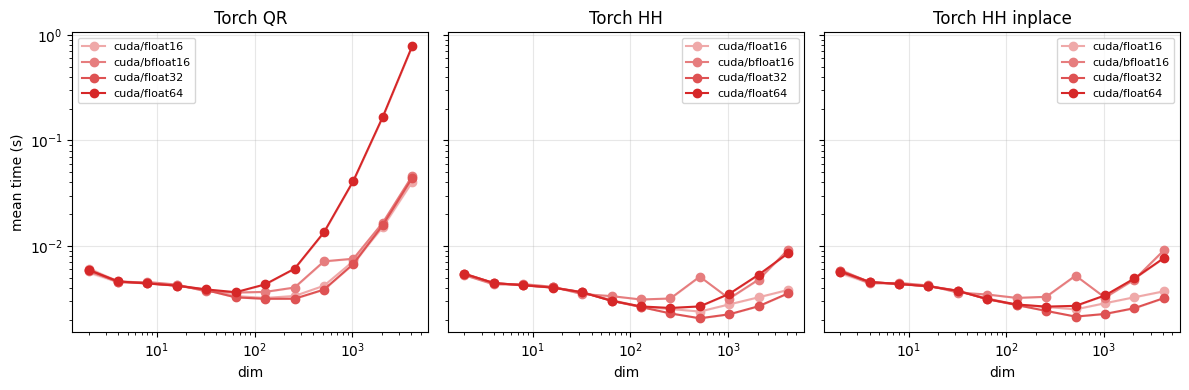

In [8]:
import numpy as np
import matplotlib.colors as mcolors

# Torch-only summary (mean/std over seeds) with method/device/dtype granularity

torch_df = df[df["backend"].str.startswith("torch")].copy()
torch_df = torch_df[torch_df["device"].isin(["cpu", "cuda"])].copy()

torch_df["method"] = np.where(
    ~torch_df["uses_householder"],
    "QR",
    np.where(torch_df["inplace"], "HH inplace", "HH"),
)

torch_summary = (
    torch_df.groupby(["method", "device", "dtype", "dim"], as_index=False)["time_s"]
    .agg(mean_time_s="mean", std_time_s="std", n="count")
)

# Dtype shading (lighter -> darker by precision)
preferred_dtypes = ["torch.float16", "torch.bfloat16", "torch.float32", "torch.float64"]
dtype_order = [d for d in preferred_dtypes if d in set(torch_summary["dtype"])]
extra_dtypes = sorted(set(torch_summary["dtype"]) - set(dtype_order))
dtype_order.extend(extra_dtypes)

shade_values = np.linspace(0.4, 1.0, max(len(dtype_order), 1))
dtype_shades = dict(zip(dtype_order, shade_values))

color_by_device = {"cpu": "tab:blue", "cuda": "tab:red"}

def shade_color(base_color: str, shade: float) -> tuple[float, float, float]:
    base = mcolors.to_rgb(base_color)
    return tuple(1 - shade * (1 - c) for c in base)

methods = ["QR", "HH", "HH inplace"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, method in zip(axes, methods):
    subset = torch_summary[torch_summary["method"] == method]
    for device in ["cpu", "cuda"]:
        for dtype in dtype_order:
            data = subset[(subset["device"] == device) & (subset["dtype"] == dtype)]
            if data.empty:
                continue
            data = data.sort_values("dim")
            shade = dtype_shades.get(dtype, 1.0)
            color = shade_color(color_by_device[device], shade)
            label = f"{device}/{dtype.split('.')[-1]}"
            ax.plot(data["dim"], data["mean_time_s"], marker="o", color=color, label=label)
            ax.fill_between(
                data["dim"],
                data["mean_time_s"] - data["std_time_s"],
                data["mean_time_s"] + data["std_time_s"],
                color=color,
                alpha=0.15,
            )

    ax.set_title(f"Torch {method}")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("mean time (s)")
for ax in axes:
    ax.set_xlabel("dim")

# Legend (unique labels per subplot)
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=8)

plt.tight_layout()
plt.show()